# Latent Dirichlet Allocation (LDA)

In [1]:
import os
import re
import json
import gensim
import pyLDAvis
import random

import numpy as np
import pandas as pd

from gensim.models.ldamulticore import LdaModel
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from sklearn.model_selection import train_test_split
from gensim.models.coherencemodel import CoherenceModel

import lib.helper as helper

from nltk.stem.porter import *

# Define which stemmer to use in the pipeline later
stemmer = PorterStemmer()

import seaborn as sns
import pyLDAvis.gensim as gensimvis
import matplotlib.pyplot as plt
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\nltk\decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""
C:\ProgramData\Anaconda3\lib\site-packages\nltk\lm\counter.py:15: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Sequence, defaultdict
C:\ProgramData\Anaconda3\lib\site-packages\nltk\lm\vocabulary.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Counter, Iterable


## 1.  Retrieve Corpus

The corpus is being scraped by the "run_news_scrapes.py" script (and windows task scheduler) every 12 hours, a bit past midday and a bit past midnight.

The "bing" corpus are news titles and text extracts gotten from the bing news search API, using a few Home Office - related keywords.

The "disaster" corpus works likewise, but with keywords relating to natural disasters

The "RSS" corpus is plugged directly into a number of RSS feeds for world news sites and local british news sites, with no filters for news story types or subjects applied.

In [2]:
# Should be same path for all my PC's, it's where each scrape goes as a separate json file.
storage_path = "D:/Dropbox/news_crow/scrape_results"

# "bing" is targeted news search corpus, "RSS" is from specific world and local news feeds.
corpus_type = "RSS"

# Load up
corpus = helper.load_clean_corpus(storage_path, corpus_type)

# Make sure after cleaning etc it's indexed from 0
corpus.reset_index(inplace=True)
corpus.index.name = "node"

# See how it turned out
print(corpus.shape)
corpus.head()

Total files: 484
9.9 percent of files read.
19.8 percent of files read.
29.8 percent of files read.
39.7 percent of files read.
49.6 percent of files read.
59.5 percent of files read.
69.4 percent of files read.
79.3 percent of files read.
89.3 percent of files read.
99.2 percent of files read.
(119964, 9)


,index,title,summary,date,link,source_url,retrieval_timestamp,origin,clean_text
node,,,,,,,,,
0,0,Hurricane Dorian lashes US as Bahamas counts cost,"Life-threatening US storm surges are feared, a...","Thu, 05 Sep 2019 16:03:44 GMT",https://www.bbc.co.uk/news/world-us-canada-495...,http://feeds.bbci.co.uk/news/world/rss.xml,2019-09-05 21:35:06.925873,rss_feed,Hurricane Dorian lashes US as Bahamas counts c...
1,1,Kohistan video murders: Three guilty in 'honou...,They are relatives of a group of Pakistani wom...,"Thu, 05 Sep 2019 13:53:17 GMT",https://www.bbc.co.uk/news/world-asia-49592540,http://feeds.bbci.co.uk/news/world/rss.xml,2019-09-05 21:35:06.925873,rss_feed,Kohistan video murders: Three guilty in 'honou...
2,2,MH17 Ukraine plane crash: 'Key witness' released,A Ukrainian court releases a potentially key w...,"Thu, 05 Sep 2019 13:46:06 GMT",https://www.bbc.co.uk/news/world-europe-49591148,http://feeds.bbci.co.uk/news/world/rss.xml,2019-09-05 21:35:06.925873,rss_feed,MH17 Ukraine plane crash: 'Key witness' releas...
3,3,Article 370: The weddings 'ruined' by Kashmir'...,Indian-administered Kashmir is under a securit...,"Thu, 05 Sep 2019 07:32:34 GMT",https://www.bbc.co.uk/news/world-asia-india-49...,http://feeds.bbci.co.uk/news/world/rss.xml,2019-09-05 21:35:06.925873,rss_feed,Article 70: The weddings 'ruined' by Kashmir's...
4,4,Syria war: Turkey warns Europe of new migrant ...,President Erdogan demands international help t...,"Thu, 05 Sep 2019 16:11:48 GMT",https://www.bbc.co.uk/news/world-europe-49599297,http://feeds.bbci.co.uk/news/world/rss.xml,2019-09-05 21:35:06.925873,rss_feed,Syria war: Turkey warns Europe of new migrant ...


## 2.  Additional preprocessing for LDA

### TODO:  Dump the stuff below into another "embedding model" in lib

In [3]:
# A quick utility function to pre-process the text
def preprocess_desc(description):
    return( [stemmer.stem(token) for token in simple_preprocess(str(description)) if token not in STOPWORDS] )

corpus["tokens"] = corpus["clean_text"].apply(preprocess_desc)

corpus.tail()

,index,title,summary,date,link,source_url,retrieval_timestamp,origin,clean_text,tokens
node,,,,,,,,,,
119959,1317473,Police identify man found dead in Boston street,An appeal to track his identity has been succe...,"Thu, 25 Jun 2020 12:00:50 +0000",https://www.lincolnshirelive.co.uk/news/local-...,http://lincolnshirelive.co.uk/news/?service=rss,2020-06-25 21:33:25.438510,rss_feed,Police identify man found dead in Boston stree...,"[polic, identifi, man, dead, boston, street, a..."
119960,1317475,Man told to remove Union Jack flags - 7 YEARS ...,The flags were up on North Promenade in Mablet...,"Thu, 25 Jun 2020 11:11:50 +0000",https://www.lincolnshirelive.co.uk/news/local-...,http://lincolnshirelive.co.uk/news/?service=rss,2020-06-25 21:33:25.438510,rss_feed,Man told to remove Union Jack flags - 7 YEARS ...,"[man, told, remov, union, jack, flag, year, to..."
119961,1317476,Weather forecast for YOUR area for the rest of...,It's going to be a hot one,"Thu, 25 Jun 2020 10:59:21 +0000",https://www.lincolnshirelive.co.uk/news/local-...,http://lincolnshirelive.co.uk/news/?service=rss,2020-06-25 21:33:25.438510,rss_feed,Weather forecast for YOUR area for the rest of...,"[weather, forecast, area, rest, week, go, hot]"
119962,1317478,"Horses charge at young boy, eat two prams and ...",“I thought the horse was going to get to my so...,"Thu, 25 Jun 2020 10:44:05 +0000",https://www.lincolnshirelive.co.uk/news/local-...,http://lincolnshirelive.co.uk/news/?service=rss,2020-06-25 21:33:25.438510,rss_feed,"Horses charge at young boy, eat two prams and ...","[hors, charg, young, boy, eat, pram, destroy, ..."
119963,1317480,Lincoln police officer suffers ‘horrific assau...,He has had to take time off work,"Thu, 25 Jun 2020 10:13:10 +0000",https://www.lincolnshirelive.co.uk/news/lincol...,http://lincolnshirelive.co.uk/news/?service=rss,2020-06-25 21:33:25.438510,rss_feed,Lincoln police officer suffers ‘horrific assau...,"[lincoln, polic, offic, suffer, horrif, assaul..."


In [4]:
# Create the vocabulary record
dictionary = gensim.corpora.Dictionary(corpus['tokens'])

# Remove extreme values (words that are too rare, too common)
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=100000)

# Create a BOW model
bow_corpus = [dictionary.doc2bow(doc) for doc in corpus['tokens']]

# From that create the TF-IDF model
# THIS IS ANOTHER POINT THE CORPUS ORDERING COULD DETATCH FROM THE RAW DATA ORDERING
tfidf = gensim.models.TfidfModel(bow_corpus)
corpus['corpus_tfidf'] = tfidf[bow_corpus]

corpus['corpus_tfidf'].head()

node
0    [(0, 0.5866958959548745), (1, 0.18419705762567...
1    [(15, 0.2650687340275726), (16, 0.339310575633...
2    [(29, 0.18791390543164188), (30, 0.12809520853...
3    [(27, 0.2203631675433624), (42, 0.322467540019...
4    [(53, 0.2155634063535501), (54, 0.196431124864...
Name: corpus_tfidf, dtype: object

## 3. Testing a range of different-sized LDA models

In [6]:
random.seed(7)
trainset, testset = train_test_split(corpus, test_size=0.15)

In [7]:
# Loop through a number of different topic model sizes

results = pd.DataFrame()
for num_topics in range(40, 91):

    # Fit the lda model, with [num_topics] topics
    lda_model_tfidf = LdaModel(trainset['corpus_tfidf'],
                               num_topics=num_topics,
                               id2word=dictionary,
                               passes=2)
    
    # Get the perplexity
    perplexity = lda_model_tfidf.log_perplexity(testset['corpus_tfidf'])
    
    # Get the coherence - using Umass here because it's fast to calculate
    cm = CoherenceModel(model=lda_model_tfidf, corpus=testset['corpus_tfidf'], coherence='u_mass')
    coherence = cm.get_coherence()
    
    # record
    results = results.append({"topics":num_topics, "perplexity":perplexity, "coherence":coherence}, ignore_index=True)
    
    # Report for my convenience
    print("tried {} topics".format(num_topics), "perplexity = {}".format(perplexity), "coherence = {}".format(coherence))

results.to_csv("working/disaster_lda_stats_clean.csv")

tried 40 topics perplexity = -19.008140182349372 coherence = -12.758828297041822
tried 41 topics perplexity = -19.24954994983792 coherence = -12.771888935867171
tried 42 topics perplexity = -19.66543742315407 coherence = -13.317443121945095
tried 43 topics perplexity = -20.06842508986285 coherence = -13.222173588658258
tried 44 topics perplexity = -20.61174723632455 coherence = -13.329615963058824
tried 45 topics perplexity = -21.036951129605516 coherence = -13.48569032677393
tried 46 topics perplexity = -21.61738289077823 coherence = -12.876407203117166
tried 47 topics perplexity = -22.327358392426817 coherence = -13.815770799325806
tried 48 topics perplexity = -22.934310021144444 coherence = -13.174666419468567
tried 49 topics perplexity = -23.97776015021016 coherence = -13.139912372158083
tried 50 topics perplexity = -24.735322903200945 coherence = -13.193381463068349
tried 51 topics perplexity = -26.052405277824285 coherence = -12.724331213850572
tried 52 topics perplexity = -27.46

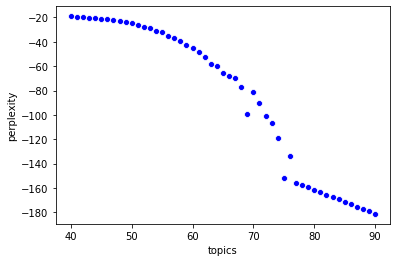

In [8]:
# plot the results - PERPLEXITY
sns.scatterplot(x="topics", y="perplexity", color="blue", data=results)

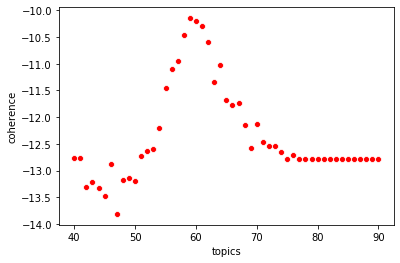

In [9]:
# plot the results - COHERENCE
sns.scatterplot(x="topics", y="coherence", color="red", data=results)

## 4. Create the "best" model using all data

And parameters decided by test-time performance on perplexity and coherence.

In [10]:
random.seed(42)

# Fit the final lda model to all data
lda_model_tfidf = LdaModel(corpus['corpus_tfidf'],
                           num_topics=60,
                           id2word=dictionary,
                           passes=2)

# Get the perplexity, out of curiosity
perplexity = lda_model_tfidf.log_perplexity(corpus['corpus_tfidf'])
    
# Get the coherence, out of curiosity
cm = CoherenceModel(model=lda_model_tfidf, corpus=corpus['corpus_tfidf'], coherence='u_mass')
coherence = cm.get_coherence()

print("perplexity = {}".format(perplexity), "coherence = {}".format(coherence))

#lda_model_tfidf.save("working/lda_model_tfidf.model")

perplexity = -44.4717486664441 coherence = -7.652659338237315


In [11]:
# Let's take a quick look at the topics picked out
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.082*"citi" + 0.045*"wednesday" + 0.042*"york" + 0.039*"believ" + 0.038*"wave" + 0.038*"new" + 0.035*"go" + 0.034*"rais" + 0.034*"lincolnshir" + 0.033*"insid"
Topic: 1 Word: 0.141*"live" + 0.060*"restaur" + 0.047*"food" + 0.044*"huge" + 0.036*"move" + 0.034*"near" + 0.032*"discov" + 0.027*"fail" + 0.026*"afternoon" + 0.024*"handl"
Topic: 2 Word: 0.000*"dorchest" + 0.000*"asthma" + 0.000*"chiropractor" + 0.000*"magnolia" + 0.000*"bettina" + 0.000*"hatchback" + 0.000*"stan" + 0.000*"hopper" + 0.000*"cuppa" + 0.000*"salmond"
Topic: 3 Word: 0.195*"week" + 0.091*"town" + 0.071*"son" + 0.051*"emerg" + 0.039*"yesterday" + 0.036*"visit" + 0.035*"queen" + 0.034*"thought" + 0.034*"dad" + 0.028*"join"
Topic: 4 Word: 0.120*"suffer" + 0.101*"coast" + 0.073*"involv" + 0.066*"passeng" + 0.056*"injuri" + 0.051*"burn" + 0.051*"boat" + 0.044*"blaze" + 0.036*"sun" + 0.034*"aliv"
Topic: 5 Word: 0.080*"mask" + 0.075*"record" + 0.063*"end" + 0.058*"break" + 0.058*"show" + 0.054*"footag" + 0.

In [12]:
# Let's take a quick look at words the topics picked out
topic_word_dist = pd.DataFrame()

for idx, topic in lda_model_tfidf.print_topics(-1):
    
    # Record the topic index in a format R will like
    topic_index = "X" + str(idx)
    
    # Record the topic's key words as a single string
    # Split the words with a newline character while we're at it!
    topic_words = " ".join([x.split("*")[1].replace('"', '').strip() for x in topic.split("+")][0:5])
    
    # Dump them to the results dataframe
    topic_word_dist = topic_word_dist.append({"topic":topic_index, "keywords":topic_words}, ignore_index=True)
    
topic_word_dist

,keywords,topic
0,citi wednesday york believ wave,X0
1,live restaur food huge move,X1
2,dorchest asthma chiropractor magnolia bettina,X2
3,week town son emerg yesterday,X3
4,suffer coast involv passeng injuri,X4
5,mask record end break show,X5
6,figur tell doctor babi best,X6
7,health need place rate imag,X7
8,polic arrest stop mum get,X8
9,west resid local owner head,X9


In [13]:
# Assign topic to document, also store the probability of that topic
doc_topics = []

count = 0
for index, row in corpus.iterrows():
    
    # Extract list of tuples of (topic, score) from the model for each doc
    topics = [x for x in lda_model_tfidf.get_document_topics(row['corpus_tfidf']) ]
    
    # Find the highest probability topic
    highest_scoring = sorted(topics, key=lambda x: x[1], reverse=True)[0]
    
    temp = {"node": int(index),
            "cluster": highest_scoring[0],
            "score": highest_scoring[1]}
    
    # Report processing progress!
    count = count + 1
    if count % 10000 == 0:
        print(count)
    
    doc_topics.append(temp)

doc_topic_dist = pd.DataFrame(doc_topics).set_index("node")

corpus = corpus.join(doc_topic_dist)

# If cluster is smaller than minimum limit, designate as outlier
cs_lookup = corpus['cluster'].value_counts().to_dict()
corpus['cluster'] = corpus['cluster'].apply(lambda x: -1 if (cs_lookup[x] < 5) else x)

corpus.to_csv("working/RSS_clustered_lda.csv", index=False)

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000


### Looking at the topic distribution, there's no obvious way to draw a line and cut off outliers

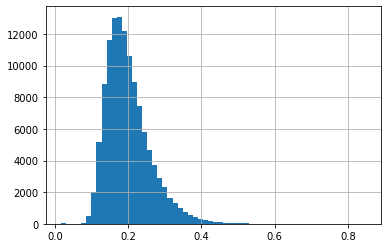

In [14]:
corpus['score'].hist(bins=60)

In [15]:
# What percentage are now classed as outliers?
100.0 * sum(corpus['cluster']==-1) / corpus.shape[0]

0.0

In [16]:
# How many unique clusters after all this?
len(pd.unique(corpus['cluster']))

48

In [17]:
corpus[corpus['score']<0.05]

,index,title,summary,date,link,source_url,retrieval_timestamp,origin,clean_text,tokens,corpus_tfidf,cluster,score
node,,,,,,,,,,,,,
1494,5214,Vegans and vegetarians may have higher stroke ...,"However, the benefits to the heart seem to out...","Thu, 05 Sep 2019 08:28:12 GMT",https://www.bbc.co.uk/news/health-49579820,http://feeds.bbci.co.uk/news/world/rss.xml,2019-09-06 12:21:43.356909,rss_feed,Vegans and vegetarians may have higher stroke ...,"[vegan, vegetarian, higher, stroke, risk, bene...","[(719, 0.29920200117228335), (933, 0.274642784...",0,0.016667
2784,20508,Forecasters predict Saharan plume to bring tem...,It's not quite Autumn yet!,"Sun, 8 Sep 2019 11:34:14 +0000",https://www.lincolnshirelive.co.uk/news/local-...,http://lincolnshirelive.co.uk/news/?service=rss,2019-09-09 00:19:56.839829,rss_feed,Forecasters predict Saharan plume to bring tem...,"[forecast, predict, saharan, plume, bring, tem...","[(1130, 0.3352762655918291), (1275, 0.26675894...",0,0.016667
4593,36413,India's Kashmir move: Two perspectives,Two Indian politicians give their separate per...,"Wed, 11 Sep 2019 22:47:30 GMT",https://www.bbc.co.uk/news/world-asia-india-49...,http://feeds.bbci.co.uk/news/world/rss.xml,2019-09-12 12:21:57.018674,rss_feed,India's Kashmir move: Two perspectives. Two In...,"[india, kashmir, perspect, indian, politician,...","[(45, 0.20356155799269543), (46, 0.55679161020...",0,0.016667
7544,64850,CSI teams in Bath,CSI teams in Bath,"Tue, 17 Sep 2019 16:01:31 +0000",https://www.somersetlive.co.uk/news/somerset-n...,http://somersetlive.co.uk/news/?service=rss,2019-09-18 00:20:03.386528,rss_feed,CSI teams in Bath. CSI teams in Bath,"[csi, team, bath, csi, team, bath]","[(346, 0.712999337883612), (5371, 0.7011647054...",0,0.016667
7798,67398,M<ichae;l jones is the new bisho of monmouth,mkgju9fsefsdhuvxc,"Wed, 18 Sep 2019 10:03:32 +0100",https://www.southwalesargus.co.uk/news/1791005...,https://www.southwalesargus.co.uk/news/rss/,2019-09-18 12:22:28.310152,rss_feed,M<ichae;l jones is the new bisho of monmouth. ...,"[icha, jone, new, bisho, monmouth]","[(60, 0.24856317934231062), (3652, 0.614189058...",0,0.016667
8136,70107,Superfast broadband rollout could be delayed u...,The existing contract has been terminated,"Wed, 18 Sep 2019 18:27:54 +0000",https://www.somersetlive.co.uk/news/somerset-n...,http://somersetlive.co.uk/news/?service=rss,2019-09-19 00:19:55.235196,rss_feed,Superfast broadband rollout could be delayed u...,"[superfast, broadband, rollout, delay, novemb,...","[(1256, 0.22428796346911853), (2071, 0.3031551...",0,0.016667
12843,116610,Apology to Fuzzy Maiava,Clarifications & Corrections: Apology to Fuzzy...,"Fri, 27 Sep 2019 22:00:14 GMT",https://www.dailymail.co.uk/news/article-75110...,https://www.dailymail.co.uk/news/articles.rss,2019-09-28 00:20:53.010191,rss_feed,Apology to Fuzzy Maiava. Clarifications Correc...,"[apolog, fuzzi, maiava, clarif, correct, apolo...","[(1129, 0.38618659483116846), (1742, 0.7565219...",0,0.016667
13358,121846,NOW AND THEN: Do you recognise this Gwent pub?,DO you recognise this Gwent pub?,"Sat, 28 Sep 2019 17:02:35 +0100",https://www.southwalesargus.co.uk/news/1793416...,https://www.southwalesargus.co.uk/news/rss/,2019-09-29 00:21:01.668335,rss_feed,NOW AND THEN: Do you recognise this Gwent pub?...,"[recognis, gwent, pub, recognis, gwent, pub]","[(2364, 0.6961100821549059), (5243, 0.50284373...",0,0.016667
16490,152513,Barbershop nominated for 'biggest award in the...,A barbershop has been nominated for “the bigge...,"Sun, 06 Oct 2019 09:36:02 +0100",https://www.theargus.co.uk/news/17949980.barbe...,https://www.theargus.co.uk/news/by_location/rss/,2019-10-06 12:23:32.315656,rss_feed,Barbershop nominated for 'biggest award in the...,"[barbershop, nomin, biggest, award, industri, ...","[(1709, 0.3596716313969343), (2464, 0.46273339...",0,0.016667
